# CART

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from eval import mean_squared_error, custom_metric

import numpy as np
import pandas as pd

from preprocess import data

np.random.seed(0)


In [11]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"][1:].reset_index(drop=True)
y_austria = data["y_austria"][1:].reset_index(drop=True)

x_germany = pd.concat([x_germany, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])
x_austria = pd.concat([x_austria, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])

## Experiments

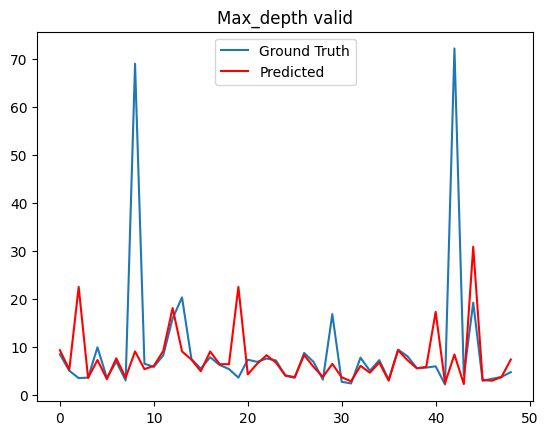

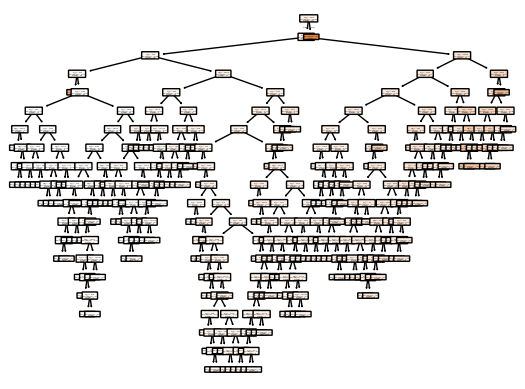

In [12]:
# Classical Train/Valid max depth

X_train, X_valid, y_train, y_valid = train_test_split(x_germany, y_germany, test_size=0.2, random_state=0)

max_depth = None  # Aucun maximum de profondeur pour un arbre maximal
regressor = DecisionTreeRegressor(max_depth=max_depth)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_valid)


plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Max_depth valid')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

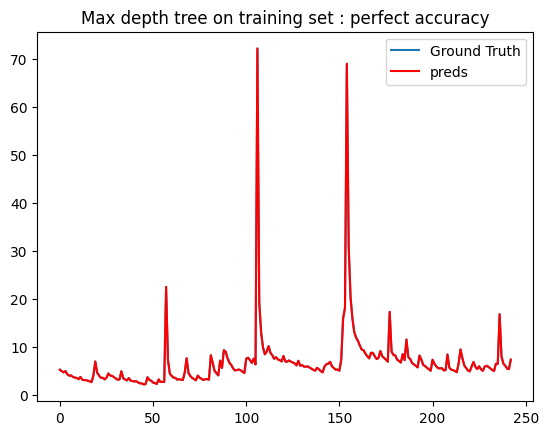

In [13]:
#Max Depth without train / valid split 

X_train = x_germany
y_train = y_germany

max_depth = None  
regressor = DecisionTreeRegressor(max_depth=max_depth)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_train)

plt.plot(y_train.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Max depth tree on training set : perfect accuracy')
plt.legend()
plt.show()

## K-folds on max_depth (no pruning)

Profondeur optimale: 3


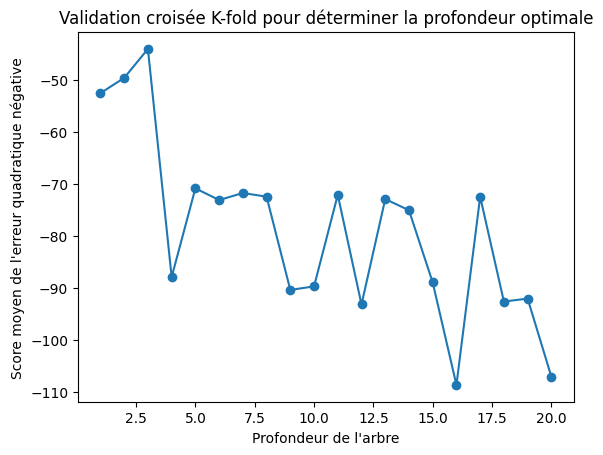

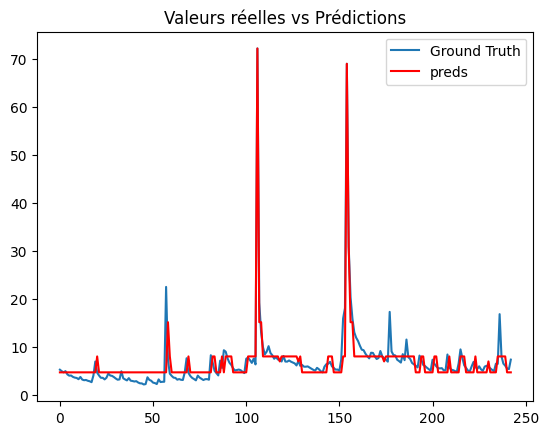

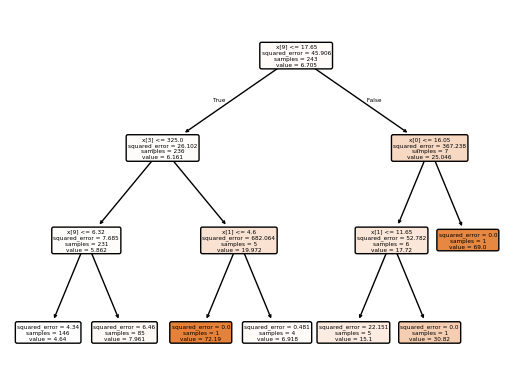

In [14]:
# Without train test split
X, y = x_germany, y_germany


# kf = KFold(n_splits=5, shuffle=True, random_state=0)
depths = range(1, 21)
mean_scores = []

for depth in depths:
    regressor = DecisionTreeRegressor(max_depth=depth)
    scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))

optimal_depth = depths[np.argmax(mean_scores)]
print(f'Profondeur optimale: {optimal_depth}')

plt.plot(depths, mean_scores, marker='o')
plt.xlabel('Profondeur de l\'arbre')
plt.ylabel('Score moyen de l\'erreur quadratique négative')
plt.title('Validation croisée K-fold pour déterminer la profondeur optimale')
plt.show()

regressor = DecisionTreeRegressor(max_depth=optimal_depth)
regressor.fit(X, y)
y_pred = regressor.predict(X)


plt.plot(y.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Valeurs réelles vs Prédictions')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

In [8]:
from eval import MAE
MAE(y_pred,y_germany)

(2.4183488500525536, 4.098171872737713)

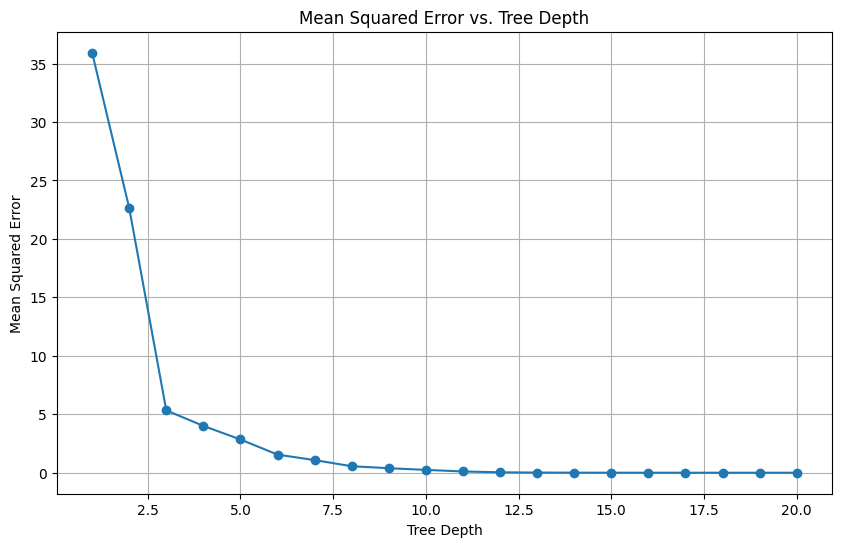

In [ ]:
X_train = x_germany
y_train = y_germany

depths = range(1, 21)

errors = []

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)

    error = mean_squared_error(y_train, y_pred)
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(depths, errors, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Tree Depth')
plt.grid(True)
plt.show()

## CART extending window no pruning

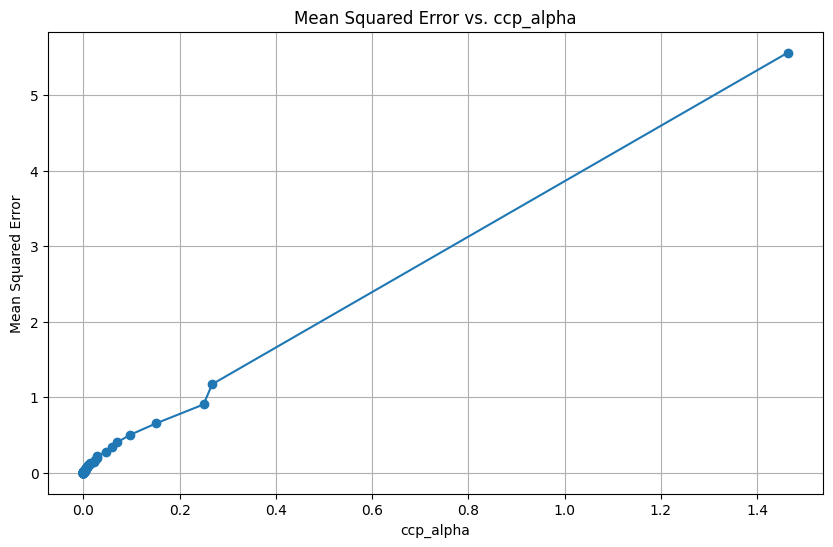

The best ccp_alpha is 0.0 with a mean squared error of 0.0


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_train = y_germany

X_train_subset = X_train[:100]
y_train_subset = y_train[:100]

model = DecisionTreeRegressor(random_state=0)
path = model.cost_complexity_pruning_path(X_train_subset, y_train_subset)
ccp_alphas = path.ccp_alphas

errors = []

for ccp_alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train_subset, y_train_subset)
    
    y_pred = model.predict(X_train_subset)
    error = mean_squared_error(y_train_subset, y_pred)
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, errors, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. ccp_alpha')
plt.grid(True)
plt.show()

best_ccp_alpha = ccp_alphas[np.argmin(errors)]
print(f'The best ccp_alpha is {best_ccp_alpha} with a mean squared error of {min(errors)}')

## CART + Ridge : k-fold, neg mse

Best ccp_alpha: 1.203493782212662


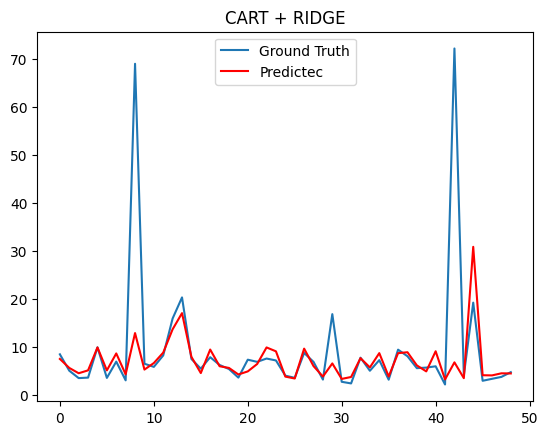

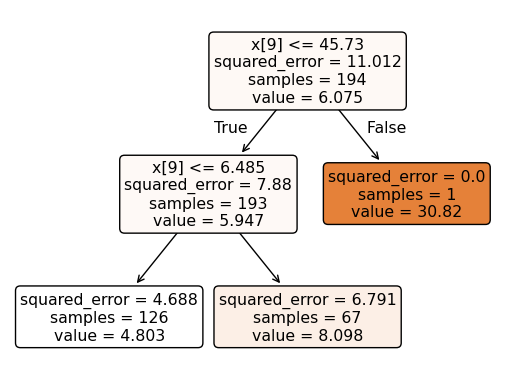

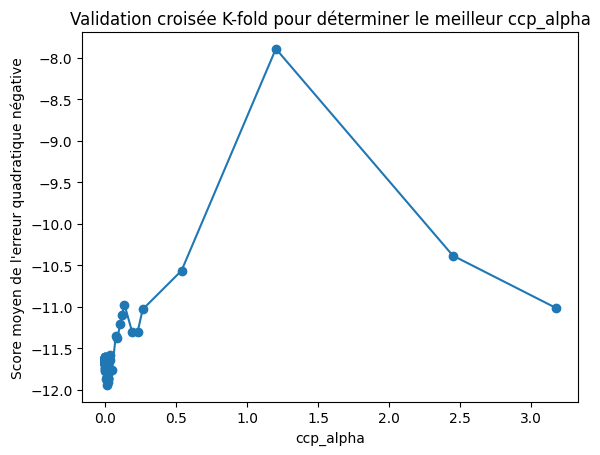

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

X, y = x_germany, y_germany


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = DecisionTreeRegressor(random_state=0, max_depth=None)
regressor.fit(X_train, y_train)

path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

kf = KFold(n_splits=5, shuffle=True, random_state=0)
mean_scores = []

for ccp_alpha in ccp_alphas:
    regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))

best_ccp_alpha = ccp_alphas[np.argmax(mean_scores)]
print(f'Best ccp_alpha: {best_ccp_alpha}')

regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=best_ccp_alpha)
regressor.fit(X_train, y_train)

leaf_indices = regressor.apply(X_train)
unique_leaves = np.unique(leaf_indices)

ridge_models = {}

for leaf in unique_leaves:
    indices = np.where(leaf_indices == leaf)
    X_leaf = X_train.iloc[indices]
    y_leaf = y_train.iloc[indices]
    ridge = Ridge()
    ridge.fit(X_leaf, y_leaf)
    ridge_models[leaf] = ridge

leaf_indices_valid = regressor.apply(X_valid)
y_pred = np.zeros_like(y_valid)

for i, leaf in enumerate(leaf_indices_valid):
    ridge = ridge_models[leaf]
    y_pred[i] = ridge.predict(X_valid.iloc[[i]])[0]
    


In [ ]:

plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='Predictec')
plt.title('CART + RIDGE')
plt.legend()
plt.show()

from sklearn.tree import plot_tree

plot_tree(regressor, filled=True, rounded=True)
plt.show()

plt.plot(ccp_alphas, mean_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Score moyen de l\'erreur quadratique négative')
plt.title('Validation croisée K-fold pour déterminer le meilleur ccp_alpha')
plt.show()

## CART + Ridge - Extended window

In [19]:
from eval import MAE


X, y = x_austria, y_austria


y_pred= []
for k in range(100, len(X)):
    X_train = X[:k]
    X_valid = X.iloc[[k]]
    y_train = y[:k]
    y_valid = y.iloc[k]
    regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
    regressor.fit(X_train, y_train)

    leaf_indices = regressor.apply(X_train)
    unique_leaves = np.unique(leaf_indices)

    ridge_models = {}

    for leaf in unique_leaves:
        indices = np.where(leaf_indices == leaf)
        X_leaf = X_train.iloc[indices]
        y_leaf = y_train.iloc[indices]
        ridge = Ridge()
        ridge.fit(X_leaf, y_leaf)
        ridge_models[leaf] = ridge
    
    y_pred.append(ridge_models[regressor.apply(X_valid)[0]].predict(X_valid))
    # y_pred.append(regressor.predict(X_valid)[0])


(2.4291547703617167, 3.1843627300814)
(1274.0913010120203, 1075.1030921005663)


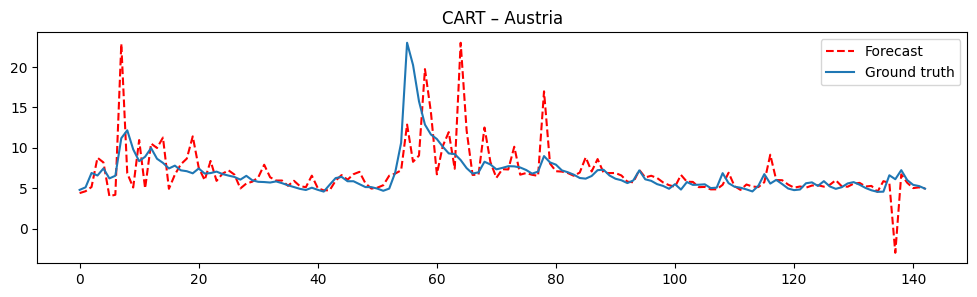

In [20]:
from eval import custom_metric

fig, ax = plt.subplots(figsize=(12, 3))

# Calculate and print metrics
print(MAE(y_pred, y[100:]))
print(custom_metric(y_pred, y[100:], country="Austria"))

# Plot the data
ax.plot(y_pred, label="Forecast", linestyle="--", color="red")
ax.plot(y.values[100:], label="Ground truth")
ax.set_title("CART – Austria")
# Add legend
ax.legend()
plt.savefig("CART.png", dpi=300)

# Show plot
plt.show()
